In [1]:
from model import *

%load_ext autoreload
%autoreload 2

In [2]:
model = load_model('sat_unet_custom.hdf5', compile=False)
# model=load_model('pretrained_unet_custom.hdf5', compile = False)
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_364 (Conv2D)             (None, 256, 256, 64) 1792        input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_403 (BatchN (None, 256, 256, 64) 256         conv2d_364[0][0]                 
__________________________________________________________________________________________________
conv2d_365 (Conv2D)             (None, 256, 256, 64) 36928       batch_normalization_403[0][0]    
___________________________________________________________________________________________

https://github.com/keisen/tf-keras-vis/blob/master/examples/attentions.ipynb

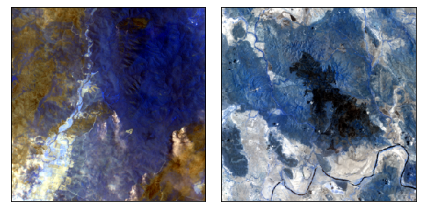

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load images
img1 = load_img('dataset/images_satellite/2MSI_20200110_S2.png', target_size=(256, 256))
img2 = load_img('dataset/images_satellite/MSI_20191224_S2.png', target_size=(256, 256))
images = np.asarray([np.array(img1), np.array(img2)])

# Prepare datasets
X = preprocess_input(images)

# Render
subprot_args = {
    'nrows': 1,
    'ncols': 2,
    'figsize': (6, 3),
    'subplot_kw': {'xticks': [], 'yticks': []}
}
f, ax = plt.subplots(**subprot_args)
for i in range(len(images)):
    ax[i].imshow(images[i])
plt.tight_layout()
plt.show()

In [4]:
def loss(output):
    return (output[0][:], output[1][:])

# Define modifier to replace a softmax function of the last layer to a linear function.
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

## Vanilla Saliency

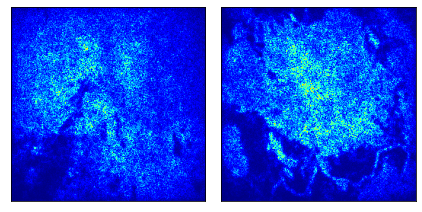

In [5]:
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

# Create Saliency object
saliency = Saliency(model, model_modifier, clone=False)

# Generate saliency map
saliency_map = saliency(loss, X)
saliency_map = normalize(saliency_map)

f, ax = plt.subplots(**subprot_args)
for i in range(len(saliency_map)):
    ax[i].imshow(saliency_map[i], cmap='jet')
plt.tight_layout()
plt.show()

## SmoothGrad

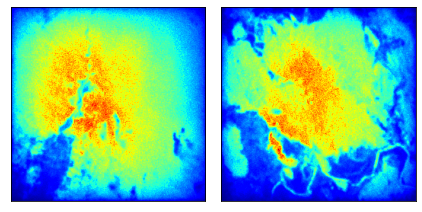

In [6]:
# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(loss, X, smooth_samples=100)
saliency_map = normalize(saliency_map)

f, ax = plt.subplots(**subprot_args)
for i in range(len(saliency_map)):
    ax[i].imshow(saliency_map[i], cmap='jet')
plt.tight_layout()
plt.show()

## GradCAM

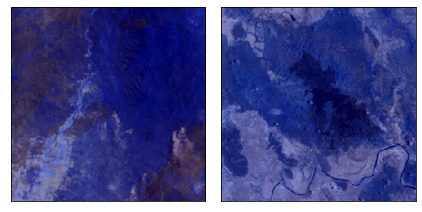

In [7]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize

# Create Gradcam object
gradcam = Gradcam(model, model_modifier, clone=False)

# Generate heatmap with GradCAM
cam = gradcam(loss, X)
cam = normalize(cam)

f, ax = plt.subplots(**subprot_args)
for i in range(len(cam)):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
%matplotlib inline
from tensorflow.keras import backend as K
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.utils.callbacks import Print

# Define modifier to replace a softmax function of the last layer to a linear function.
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear

# Create Activation Maximization object
activation_maximization = ActivationMaximization(model, model_modifier)

loss = lambda x: K.mean(x[:, :])

# Generate max activation with debug printing
activation = activation_maximization(loss, steps=512, callbacks=[Print(interval=100)])
image = activation[0].astype(np.uint8)

f, ax = plt.subplots(figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)
plt.show()